# ДЗ 5 - Работа с линейными моделями

## Данные: 
CSV-файл, где каждая строка – условный клиент банка с набором финансовых и поведенческих признаков.

## Цель:
Предсказать target-переменную - `default` (дефолт по кредиту)

In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    brier_score_loss,
    average_precision_score,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

RANDOM_STATE = 42

In [2]:
df = pd.read_csv("./data/S05-hw-dataset.csv")
df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [4]:
df.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [5]:
df.isna().sum()

client_id                         0
age                               0
income                            0
years_employed                    0
credit_score                      0
debt_to_income                    0
num_credit_cards                  0
num_late_payments                 0
has_mortgage                      0
has_car_loan                      0
savings_balance                   0
checking_balance                  0
region_risk_score                 0
phone_calls_to_support_last_3m    0
active_loans                      0
customer_tenure_years             0
default                           0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df["default"].value_counts(normalize=True)

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

В датасете 3 тысячи наюлюдений, из которых: *41%* - дефолтные случаи, а остальные *59%* - кредитоспособные клиенты.
Кажется, что данные хорошие: пропусков и дубликатов нет, а все значения статистик в предалх нормы. В качестве признаков модели можно использовать все параметры, кроме `clinet_id`, посклольку он не влияет на дефолт по кредиту (итого: 15 параметров).

In [8]:
features = [
    "age", "income", "years_employed",
    "credit_score", "debt_to_income", "num_credit_cards",
    "num_late_payments", "has_mortgage", "has_car_loan",
    "savings_balance", "checking_balance", "region_risk_score", 
    "phone_calls_to_support_last_3m", "active_loans", "customer_tenure_years"
]

X = df[features]
y = df["default"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE,
)

In [10]:
print("Размеры выборок:")
print("  train:", X_train.shape)
print("  test: ", X_test.shape)

Размеры выборок:
  train: (2250, 15)
  test:  (750, 15)


In [11]:
print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))


Распределение классов (train):
default
0    0.589778
1    0.410222
Name: proportion, dtype: float64

Распределение классов (test):
default
0    0.589333
1    0.410667
Name: proportion, dtype: float64


Для начала реализуем baseline-модель, которая будет делать предсказание, исходя из самого встречаемого в датасете класса

In [12]:
baseline = DummyClassifier(
    strategy="most_frequent",
    random_state=RANDOM_STATE
)

baseline.fit(X_train, y_train)

,strategy,'most_frequent'
,random_state,42
,constant,None


In [13]:
y_pred_baseline = baseline.predict(X_test)
y_proba_baseline = baseline.predict_proba(y_test)[:, 1]

In [14]:
print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===")
print("Accuracy :", accuracy_score(y_test, y_pred_baseline))
print("Precision:", precision_score(y_test, y_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_baseline, zero_division=0))

=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===
Accuracy : 0.5893333333333334
Precision: 0.0
Recall   : 0.0
F1-score : 0.0


In [15]:
try:
    print("ROC-AUC  :", roc_auc_score(y_test, y_proba_baseline))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

ROC-AUC  : 0.5


Из метрик видно, что это модель вообще не использует параметры. ROC-AUC = 0.5 - случайный классификатор. Используем её метрики как базовый минимум.

Далее реализуем `pipeline`, куда включим препроцессинг в виде стандатизации (у признаков слишком большй размах) и логистическую регрессию в виде модели.

In [16]:
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ]
)

log_reg_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [17]:
y_test_pred = log_reg_pipeline.predict(X_test)
y_test_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_pred))

Accuracy : 0.7933333333333333
Precision: 0.7802197802197802
Recall   : 0.6915584415584416
F1-score : 0.7332185886402753
ROC-AUC  : 0.7779059176118


In [18]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid={"logreg__C": [0.01, 0.1, 1.0, 10.0]},
    scoring="f1", cv=cv, n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1 (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры: {'logreg__C': 1.0}
Лучший F1 (по CV): 0.7330236835791504


In [19]:
y_with_best_C_pred = grid_search.predict(X_test)
y_with_best_C_proba = grid_search.predict_proba(X_test)[:, 1]

print(f"=== Логистическая регрессия ({grid_search.best_params_}) ===")
print("Accuracy :", accuracy_score(y_test, y_with_best_C_pred))
print("Precision:", precision_score(y_test, y_with_best_C_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_with_best_C_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_with_best_C_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_with_best_C_proba))

=== Логистическая регрессия ({'logreg__C': 1.0}) ===
Accuracy : 0.7933333333333333
Precision: 0.7802197802197802
Recall   : 0.6915584415584416
F1-score : 0.7332185886402753
ROC-AUC  : 0.8647088205911735


In [20]:
os.makedirs("./figures", exist_ok=True) # папка для графиков

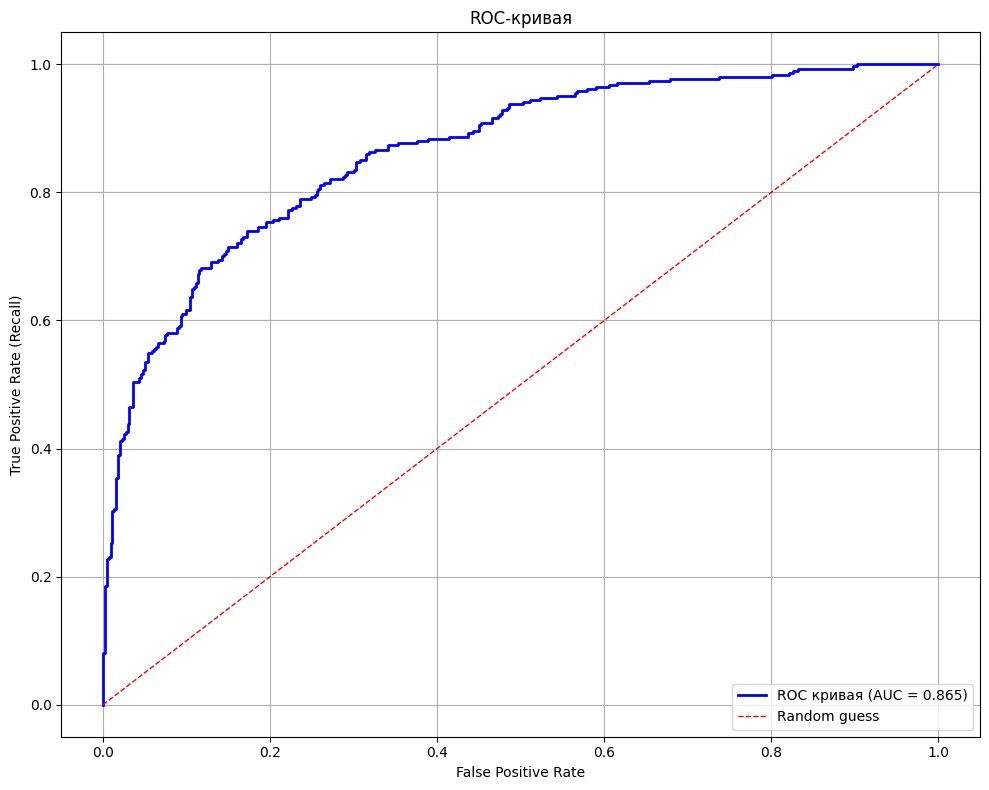

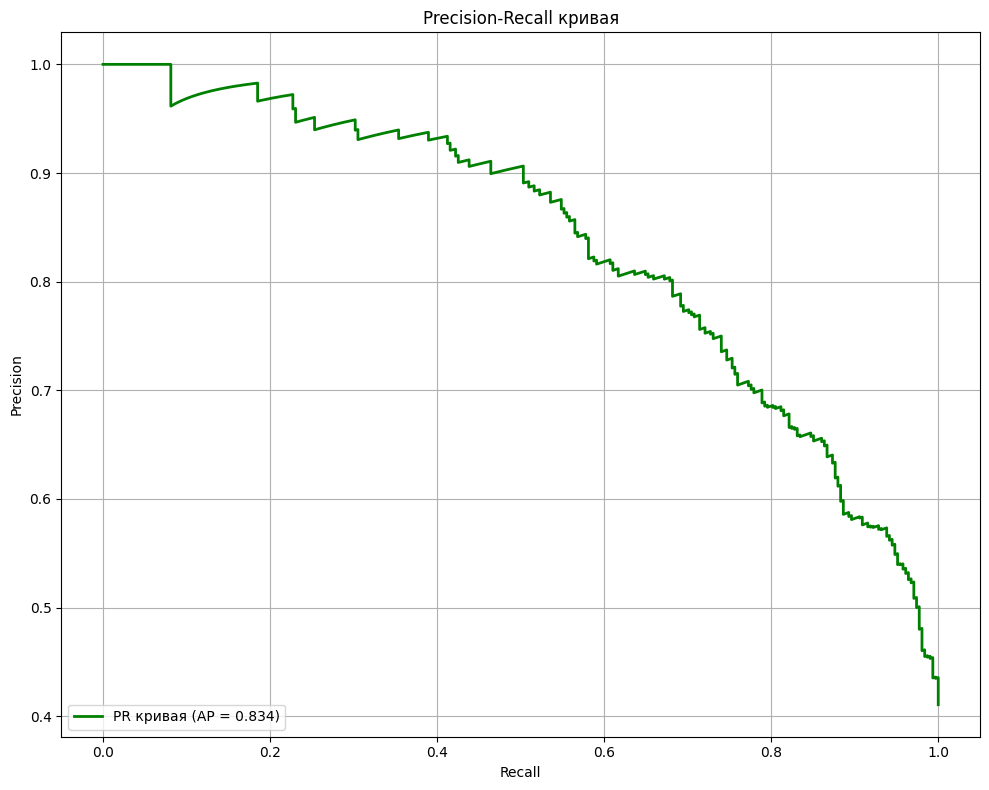

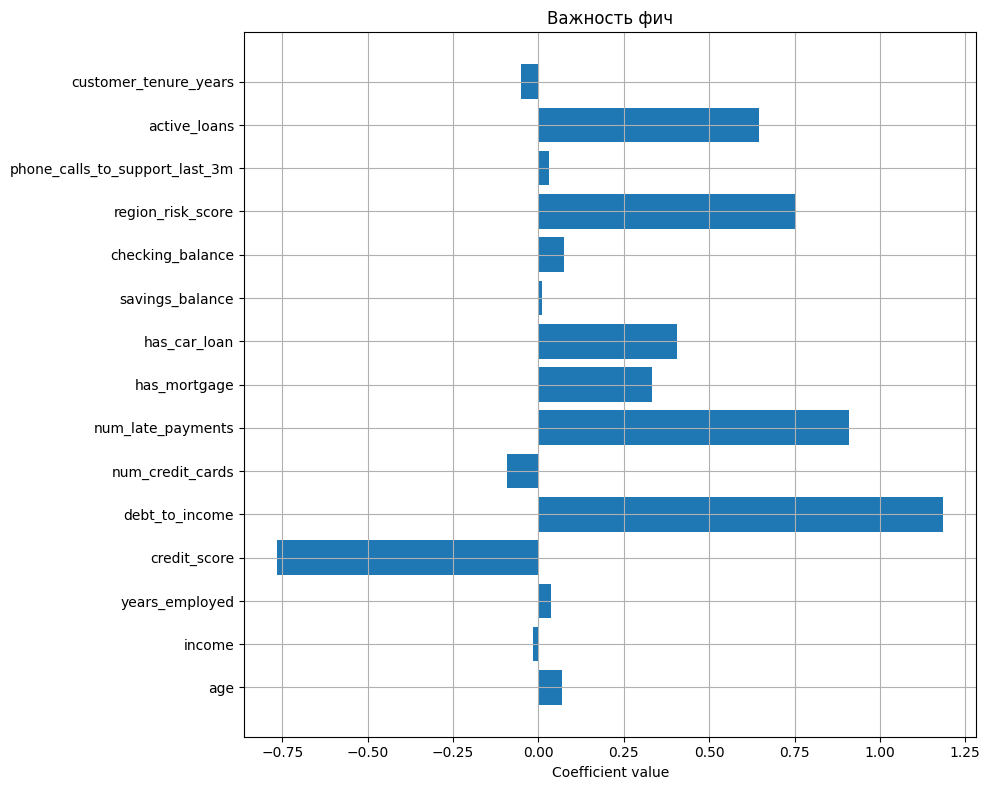

In [21]:
y_proba = grid_search.predict_proba(X_test)[:, 1] # вероятности предскзния пложительного класса

fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/roc_curve.png")

# Precision-Recall
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='green', lw=2, label=f'PR кривая (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/pr_curve.png")

# Вклад фич в таргет
coefs = grid_search.best_estimator_.named_steps['logreg'].coef_[0]
plt.figure(figsize=(10,8))
plt.barh(features, coefs)
plt.xlabel("Coefficient value")
plt.title("Важность фич")
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/feature_importance.png")

In [22]:
def compute_metrics(y_true, y_pred, y_proba):
    """
    Для объединения в DataFrame
    """
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_proba)
    }

In [23]:
metrics_baseline = compute_metrics(y_test, y_pred_baseline, y_proba_baseline)
metrics_logreg = compute_metrics(y_test, y_with_best_C_pred, y_with_best_C_proba)

df_metrics = pd.DataFrame(
    [metrics_baseline, metrics_logreg],
    index=["DummyClassifier", "LogisticRegression"]
)
df_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC
DummyClassifier,0.589333,0.00000,0.000000,0.000000,0.500000
LogisticRegression,0.793333,0.78022,0.691558,0.733219,0.864709


# Сравнение моделей: DummyClassifier vs LogisticRegression

## 1. Разница между бейзлайном и логистической регрессией

**DummyClassifier** (стратегия `most_frequent`) всегда предсказывает самый частый класс.  
В наших данных: дефолт = 41%, нормальные клиенты = 59%, т.е. Dummy всегда предсказывает "нормальный" клиент.  

Метрики DummyClassifier:

| Metric     | Value  |
|------------|--------|
| Accuracy   | 0.589  |
| Precision  | 0.0    |
| Recall     | 0.0    |
| F1-score   | 0.0    |
| ROC-AUC    | 0.5    |

**LogisticRegression** учитывает все признаки и выдает вероятности дефолта.  

Метрики LogisticRegression:

| Metric     | Value  |
|------------|--------|
| Accuracy   | 0.793  |
| Precision  | 0.78   |
| Recall     | 0.69   |
| F1-score   | 0.73   |
| ROC-AUC    | 0.865  |

> Логрег реально учится различать дефолтных и нормальных клиентов, тогда как DummyClassifier ничего не узнаёт

---

## 2. Насколько выросли метрики

- **Accuracy:** с 0.589 => 0.793 (выросло около 20%)  
- **ROC-AUC:** с 0.5 => 0.865 (значительно)

> Модель показывает реальную способность разделять классы и полезность для предсказания дефолта

---

## 3. Влияние регуляризации (параметр C)

- `C=0.01` → сильная регуляризация, модель может **недообучаться**  
- `C=10` → слабая регуляризация, модель может **переобучаться**  
- `C=1.0` → оптимальный баланс, обеспечивающий хороший F1 и Recall  

> Небольшие изменения C влияют на метрики, но выбор C = `1.0` компромиссный

---

## 4. Выводы

1. `LogisticRegression` существенно лучше бейзлайна по всем метрикам и подходит для задачи предсказания дефолта.  
2. `Accuracy и ROC-AUC` выросли сильно, что подтверждает улучшение качества модели по сравнению с наивным предсказанием.  
3. `Выбор C = 1.0` обеспечивает баланс между гибкостью модели и её стабильностью, при этом хорошо ловятся дефолтные клиенты.  

